In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [90]:
def read_and_split(path='../data/processed/processed_data.csv'):
    df_full = pd.read_csv(path)
    pos = df_full[df_full.faultInducingBool == 1].copy().reset_index(drop=True)
    neg = df_full[df_full.faultInducingBool == 0].sample(n=1000, random_state=42)
    neg.dropna(inplace=True)
    df_red = pd.concat([neg, pos], axis=0)
    X = df_red.drop(columns=['faultInducingBool']).to_numpy()
    y = df_red.faultInducingBool.to_numpy()
    trX, valX, trY, valY = train_test_split(X, y, test_size=0.25, random_state=42)
    return trX, valX, trY, valY, df_red.drop(columns=['faultInducingBool']).columns

In [91]:
trX, valX, trY, valY, feat_cols = read_and_split()

In [92]:
feat_cols

Index(['inMainBranch', 'maxComplexity', 'meanComplexity', 'totalLinesAdded',
       'totalLinesRemoved', 'totalNloc', 'maxTokenCount', 'meanTokenCount',
       'changedFiles', 'dayOfWeek_0', 'dayOfWeek_1', 'dayOfWeek_2',
       'dayOfWeek_3', 'dayOfWeek_4', 'dayOfWeek_5', 'dayOfWeek_6',
       'committerHourOfDay'],
      dtype='object')

In [97]:
rf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42)
rf.fit(trX, trY)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

In [98]:
tr_preds = rf.predict(trX)
val_preds = rf.predict(valX)

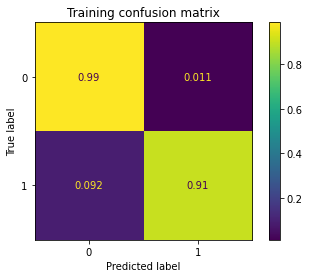

Recall is 0.9081632653061225
Precision is 0.9823399558498896
F1 Score is 0.9437963944856841


In [99]:
ConfusionMatrixDisplay(confusion_matrix(trY, tr_preds, normalize='true'), display_labels=['0', '1']).plot()
plt.title('Training confusion matrix')
plt.show()
print('Recall is {}'.format(recall_score(trY, tr_preds)))
print('Precision is {}'.format(precision_score(trY, tr_preds)))
print('F1 Score is {}'.format(f1_score(trY, tr_preds)))

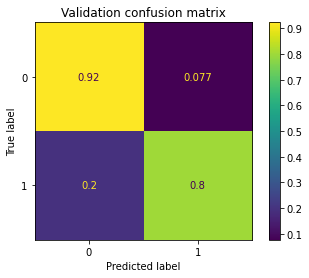

Recall is 0.8012422360248447
Precision is 0.8716216216216216
F1 Score is 0.8349514563106796


In [100]:
ConfusionMatrixDisplay(confusion_matrix(valY, val_preds, normalize='true'), display_labels=['0', '1']).plot()
plt.title('Validation confusion matrix')
plt.show()
print('Recall is {}'.format(recall_score(valY, val_preds)))
print('Precision is {}'.format(precision_score(valY, val_preds)))
print('F1 Score is {}'.format(f1_score(valY, val_preds)))

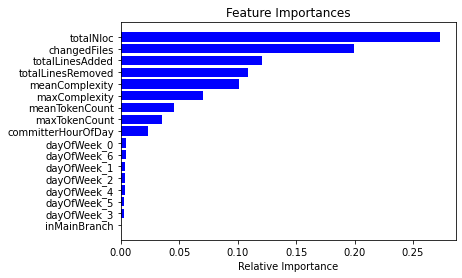

In [101]:
features = feat_cols.tolist()
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()